# Initialize Packages and Define Constants

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import scipy

# define useful constants
hbar_eV = 6.582e-16
mub_eV = 5.788e-5
kb_eV = 8.617e-5
gyr_e = (2.002*mub_eV)/hbar_eV
gyr_n = 2*np.pi*7.623e6
kcalmol_to_eV = 0.043

# free energy values for P450 from Shaik, et al. Nat. Chem. (2010)
triplet_G = 0*kcalmol_to_eV
triplet_TS_G = 9.6*kcalmol_to_eV
quintet_G = 5.8*kcalmol_to_eV
quintet_TS_G = 7.3*kcalmol_to_eV

In [619]:
tau = [qt.sigmax(),qt.sigmay(),qt.sigmaz()] # vector of pauli matrices
def SpinSystemGen(n):
    S_i = []
    for i in range(n):
        temp = []
        for s in tau:
            ops = [qt.qeye(2)]*n
            ops[i] = s
            temp.append(qt.tensor(ops))
        S_i.apppend(temp)
    S = [sum(S_i[j][k] for j in range(n)) for k in range(len(tau))]
    eigsys = (sum(S[i]*S[i] for i in range(len(tau)))/4).eigenstates()
    eigmat = eigsys[1][0][:]
    for i in range(2**n):
        if i != 0:
            eigmat = np.append(eigmat,eigsys[1][i][:],axis=1)
    eigmat = qt.Qobj(eigmat, dims = S[0].dims)
    return S_i, S, eigsys, eigmat

# P450-I with Hyperfine change

In [ ]:
# define spin matrix vectors
S_1 = [qt.tensor(sigma,qt.qeye(2),qt.qeye(3),qt.qeye(2)) for sigma in tau]
S_2g = [qt.tensor(qt.qeye(2),sigma,qt.basis(3,1)*qt.basis(3,1).dag(),qt.qeye(2)) for sigma in tau]
S_2e = [qt.tensor(qt.qeye(2),sigma,qt.basis(3,2)*qt.basis(3,2).dag(),qt.qeye(2)) for sigma in tau]
S_I = [qt.tensor(qt.qeye(2),qt.qeye(2),qt.qeye(3),sigma) for sigma in tau]

# orbital excitation
dQ = quintet_G-triplet_G
He = qt.tensor(qt.qeye(2),qt.qeye(2),(dQ/hbar_eV)*qt.basis(3,2)*qt.basis(3,2).dag(),qt.qeye(2))

# zeeman terms in earth's magnetic field
bz = 60e-6
Hb_1 = gyr_e*bz*S_1[2]
Hb_2g = gyr_e*bz*S_2g[2]
Hb_2e = gyr_e*bz*S_2e[2]
Hb_I = gyr_n*bz*S_I[2]

# hyperfine change
dA = 1
Hhf_2e = ((dA*2.002*mub_eV)/hbar_eV)*(S_2e[0]*S_I[0]+S_2e[1]*S_I[1])

# total hamiltonian
Hsim = He+Hb_1+Hb_2g+Hb_2e+Hb_I+Hhf_2e

In [ ]:
# define ground orbital eigenstates
s0_g = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(3,1),qt.basis(2,0))-qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(3,1),qt.basis(2,0)))
t0_g = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(3,1),qt.basis(2,0))+qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(3,1),qt.basis(2,0)))
tp_g = qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(3,1),qt.basis(2,0))
tm_g = qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(3,1),qt.basis(2,0))

# define excited orbital eigenstates
s0_e = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(3,2),qt.basis(2,0))-qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(3,2),qt.basis(2,0)))
t0_e = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(3,2),qt.basis(2,0))+qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(3,2),qt.basis(2,0)))
tp_e = qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(3,2),qt.basis(2,0))
tm_e = qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(3,2),qt.basis(2,0))

## Dynamics with initial state as ground singlet

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.16s. Est. time left: 00:00:00:00
30.0%. Run time:   0.23s. Est. time left: 00:00:00:00


c:\Users\gbim9\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


40.0%. Run time:   0.31s. Est. time left: 00:00:00:00
50.0%. Run time:   0.39s. Est. time left: 00:00:00:00
60.0%. Run time:   0.46s. Est. time left: 00:00:00:00
70.0%. Run time:   0.53s. Est. time left: 00:00:00:00
80.0%. Run time:   0.61s. Est. time left: 00:00:00:00
90.0%. Run time:   0.68s. Est. time left: 00:00:00:00
100.0%. Run time:   0.76s. Est. time left: 00:00:00:00
Total run time:   0.76s


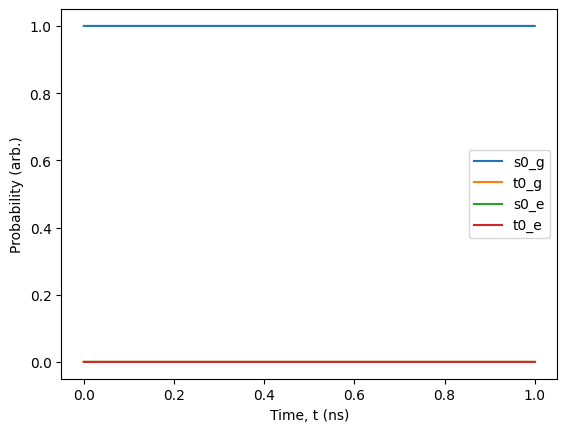

In [623]:
tlist = np.linspace(0,1e-9,10001)

result = qt.sesolve(
    Hsim,
    s0_g,
    tlist,
    e_ops = [s0_g.proj(),t0_g.proj(),s0_e.proj(),t0_e.proj()],
    options = qt.Options(progress_bar='text'),
)

expect_label = ['s0_g','t0_g','s0_e','t0_e']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();
plt.legend()

## Dynamics with initial state as excited singlet

10.0%. Run time:   1.34s. Est. time left: 00:00:00:12
20.0%. Run time:   2.70s. Est. time left: 00:00:00:10
30.0%. Run time:   4.11s. Est. time left: 00:00:00:09
40.0%. Run time:   5.47s. Est. time left: 00:00:00:08
50.0%. Run time:   6.82s. Est. time left: 00:00:00:06
60.0%. Run time:   8.19s. Est. time left: 00:00:00:05
70.0%. Run time:   9.50s. Est. time left: 00:00:00:04
80.0%. Run time:  10.91s. Est. time left: 00:00:00:02
90.0%. Run time:  12.35s. Est. time left: 00:00:00:01
100.0%. Run time:  13.82s. Est. time left: 00:00:00:00
Total run time:  13.82s


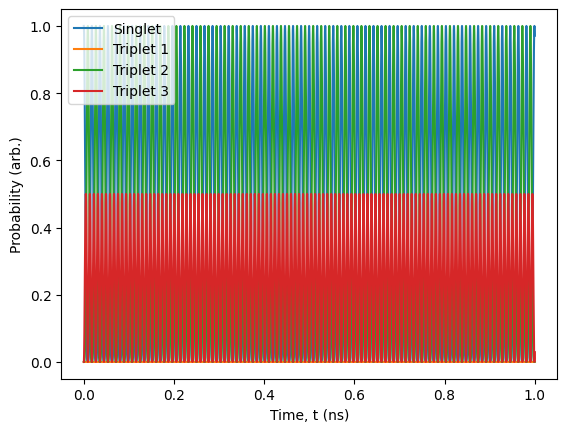

In [626]:
tlist = np.linspace(0,1e-9,10001)

result = qt.sesolve(
    Hsim,
    s0_e,
    tlist,
    e_ops = [qt.tensor(qt.singlet_state().proj(),qt.qeye(3),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[0].proj(),qt.qeye(3),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[1].proj(),qt.qeye(3),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[2].proj(),qt.qeye(3),qt.qeye(2))],
    options = {'progress_bar':'text'},
)

expect_label = ['Singlet','Triplet 1','Triplet 2','Triplet 3']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();

### Zoom in 

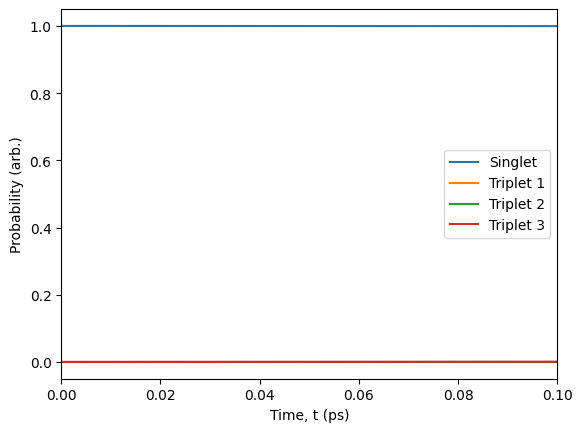

In [627]:
expect_label = ['Singlet','Triplet 1','Triplet 2','Triplet 3']
[plt.plot(tlist*1e12,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ps)')
plt.ylabel('Probability (arb.)')
plt.xlim([0,0.1])
plt.legend();

## Add dissipation

In [ ]:
# P450 relaxation data from Onderko, et al. JACS (2025)
T_sweep = np.array([10,10,15,15,17.5,20,20,25,30,30,35,40,40,50,60,60,100,100])
W_sweep = np.array([2.4,2.3,5.5,6.5,8.1,14.6,17.2,34.8,86.8,73.4,137.4,174.1,200.3,493.5,446.2,451.2,1358.1,2783.2])
t1_sweep = 1/(W_sweep*1e6)

T1 @ 300 K: 16.346990517132514 ps


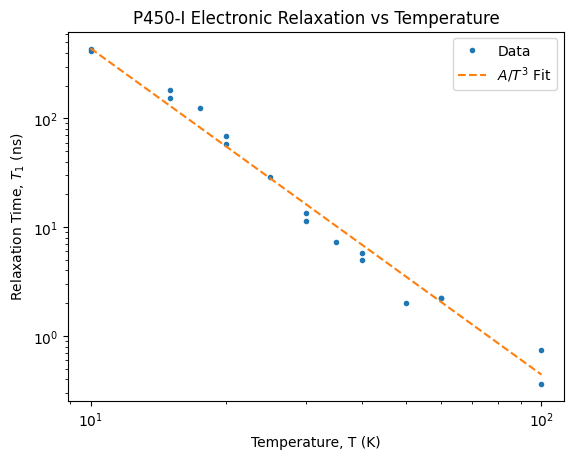

In [ ]:
# relaxation data fits well to 1/T^3, indicating a phonon-dominated process like in the Debye model
def t1_fit(T,a):
    return a/T**3

popt_t1,pcov_t1 = scipy.optimize.curve_fit(t1_fit,T_sweep,t1_sweep)
print('T1 @ 300 K: '+str(t1_fit(300,*popt_t1)*1e12)+' ps')
T_test = np.logspace(1,2,101)

plt.loglog(T_sweep,t1_sweep*1e9,'.',label='Data')
plt.loglog(T_test,t1_fit(T_test,*popt_t1)*1e9,'--',label='$A/T^{3}$ Fit')
plt.xlabel('Temperature, T (K)')
plt.ylabel('Relaxation Time, $T_{1}$ (ns)')
plt.title('P450-I Electronic Relaxation vs Temperature')
plt.legend();

In [628]:
# extraoplate relaxation data to room temperature, define relaxation collapse operators
T = 300
relax_down = qt.tensor(qt.singlet_state().proj(),qt.basis(3,1)*qt.basis(3,2).dag(),qt.qeye(2))
rate_down = 1/t1_fit(T,*popt_t1)
relax_up = qt.tensor(qt.singlet_state().proj(),qt.basis(3,2)*qt.basis(3,1).dag(),qt.qeye(2))
rate_up = rate_down/(np.exp(dQ/(kb_eV*T))-1)
print('Adiabatic Population in Excited State: '+str(1/(np.exp(dQ/(kb_eV*T))-1)))

# define reaction collapse operators for different spin states
react_triplet = qt.tensor(qt.singlet_state().proj(),qt.basis(3,0)*qt.basis(3,1).dag(),qt.qeye(2))
kf_triplet = (kb_eV*T*np.exp(-(triplet_TS_G-triplet_G)/(kb_eV*T)))/(hbar_eV*2*np.pi)
print('Reaction rate for triplet state: '+str(kf_triplet*1e-6)+' MHz')

react_quintet = sum(qt.tensor(state.proj(),qt.basis(3,0)*qt.basis(3,2).dag(),qt.qeye(2)) for state in qt.triplet_states())
kf_quintet = (kb_eV*T*np.exp(-(quintet_TS_G-quintet_G)/(kb_eV*T)))/(hbar_eV*2*np.pi)
print('Reaction rate for quintet state: '+str(kf_quintet*1e-6)+' MHz')

Adiabatic Population in Excited State: 6.458481382260101e-05
Reaction rate for triplet state: 0.7259999950263226 MHz
Reaction rate for quintet state: 515638.55793225876 MHz


## Dissipative dynamics with initial state as excited singlet, relaxation only

10.0%. Run time:   0.21s. Est. time left: 00:00:00:01
20.0%. Run time:   0.48s. Est. time left: 00:00:00:01
30.0%. Run time:   0.67s. Est. time left: 00:00:00:01
40.0%. Run time:   0.87s. Est. time left: 00:00:00:01
50.0%. Run time:   1.03s. Est. time left: 00:00:00:01
60.0%. Run time:   1.20s. Est. time left: 00:00:00:00
70.0%. Run time:   1.45s. Est. time left: 00:00:00:00
80.0%. Run time:   1.73s. Est. time left: 00:00:00:00
90.0%. Run time:   1.88s. Est. time left: 00:00:00:00
100.0%. Run time:   2.03s. Est. time left: 00:00:00:00
Total run time:   2.03s


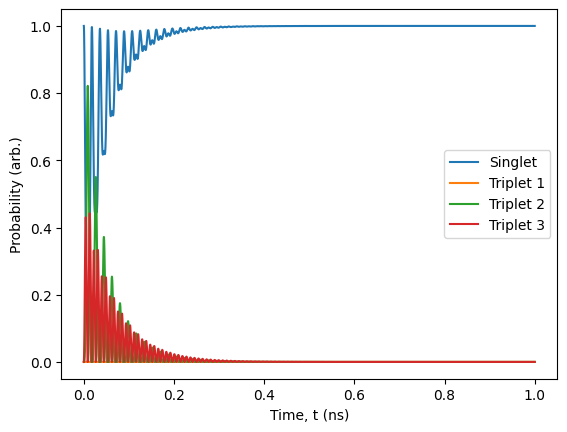

In [ ]:
tlist = np.linspace(0,1e-9,10001)

result = qt.mesolve(
    Hsim,
    s0_e*s0_e.dag(),
    tlist,
    c_ops = [np.sqrt(rate_down)*relax_down, np.sqrt(rate_up)*relax_up],
    e_ops = [qt.tensor(qt.singlet_state().proj(),qt.qeye(3),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[0].proj(),qt.qeye(3),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[1].proj(),qt.qeye(3),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[2].proj(),qt.qeye(3),qt.qeye(2))],
    options = qt.Options(progress_bar='text'),
)

expect_label = ['Singlet','Triplet 1','Triplet 2','Triplet 3']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();

## Dissipative dynamics with initial state as excited singlet, relaxation and reaction

10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.41s. Est. time left: 00:00:00:00
40.0%. Run time:   0.53s. Est. time left: 00:00:00:00
50.0%. Run time:   0.67s. Est. time left: 00:00:00:00
60.0%. Run time:   0.85s. Est. time left: 00:00:00:00
70.0%. Run time:   0.96s. Est. time left: 00:00:00:00
80.0%. Run time:   1.08s. Est. time left: 00:00:00:00
90.0%. Run time:   1.21s. Est. time left: 00:00:00:00
100.0%. Run time:   1.34s. Est. time left: 00:00:00:00
Total run time:   1.34s


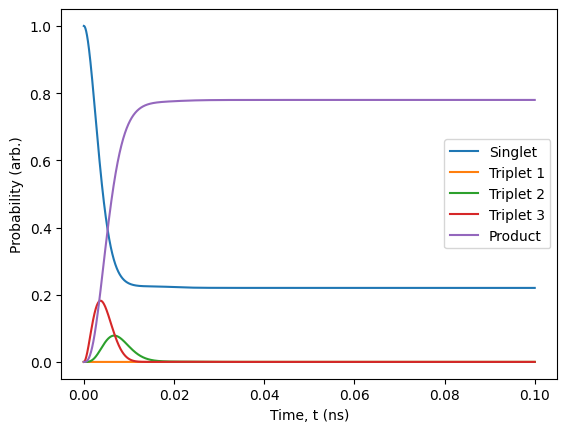

In [ ]:
tlist = np.linspace(0,0.1e-9,10001)

result = qt.mesolve(
    Hsim+qt.tensor(qt.qeye(2),qt.qeye(2),qt.basis(3,0).proj(),qt.qeye(2))/hbar_eV,
    s0_e*s0_e.dag(),
    tlist,
    c_ops = [np.sqrt(rate_down)*relax_down,
             np.sqrt(rate_up)*relax_up,
             np.sqrt(kf_triplet)*react_triplet,
             np.sqrt(kf_quintet)*react_quintet],
    e_ops = [qt.tensor(qt.singlet_state().proj(),qt.basis(3,1).proj()+qt.basis(3,2).proj(),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[0].proj(),qt.basis(3,1).proj()+qt.basis(3,2).proj(),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[1].proj(),qt.basis(3,1).proj()+qt.basis(3,2).proj(),qt.qeye(2)),
             qt.tensor(qt.triplet_states()[2].proj(),qt.basis(3,1).proj()+qt.basis(3,2).proj(),qt.qeye(2)),
             qt.tensor(qt.qeye(2),qt.qeye(2),qt.basis(3,0).proj(),qt.qeye(2))],
    options = qt.Options(progress_bar='text'),
)

expect_label = ['Singlet','Triplet 1','Triplet 2','Triplet 3','Product']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();

## Dissipative dynamics vs $\Delta A$

In [ ]:
T = 300
relax_down = qt.tensor(qt.qeye(2),qt.qeye(2),qt.basis(3,1)*qt.basis(3,2).dag(),qt.qeye(2))
rate_down = 1/t1_fit(T,*popt_t1)
relax_up = qt.tensor(qt.qeye(2),qt.qeye(2),qt.basis(3,2)*qt.basis(3,1).dag(),qt.qeye(2))
rate_up = rate_down/(np.exp(dQ/(kb_eV*T))-1)

kcalmol2eV = 0.043
react_triplet = qt.tensor(qt.singlet_state().proj(),qt.basis(3,0)*qt.basis(3,1).dag(),qt.qeye(2))
triplet_G = 0*kcalmol2eV
triplet_TS_G = 9.6*kcalmol2eV
kf_triplet = (kb_eV*T*np.exp(-(triplet_TS_G-triplet_G)/(kb_eV*T)))/(hbar_eV*2*np.pi)

react_quintet = sum(qt.tensor(state.proj(),qt.basis(3,0)*qt.basis(3,2).dag(),qt.qeye(2)) for state in qt.triplet_states())
quintet_G = 5.8*kcalmol2eV
quintet_TS_G = 7.3*kcalmol2eV
kf_quintet = (kb_eV*T*np.exp(-(quintet_TS_G-quintet_G)/(kb_eV*T)))/(hbar_eV*2*np.pi)

dA_sweep = np.linspace(-1,1,101)
tlist = np.linspace(0,0.1e-9,10001)
expect_s0_sweep = np.zeros((len(dA_sweep),len(tlist)))
expect_tm_sweep = np.zeros((len(dA_sweep),len(tlist)))
expect_t0_sweep = np.zeros((len(dA_sweep),len(tlist)))
expect_tp_sweep = np.zeros((len(dA_sweep),len(tlist)))
expect_p_sweep = np.zeros((len(dA_sweep),len(tlist)))

for i,da in enumerate(dA_sweep):
        dQ = 0.3
        He = qt.tensor(qt.qeye(2),qt.qeye(2),(dQ/hbar_eV)*qt.basis(3,2)*qt.basis(3,2).dag(),qt.qeye(2))
        bz = 60e-6
        Hb_1 = gyr_e*bz*S_1[2]
        Hb_2g = gyr_e*bz*S_2g[2]
        Hb_2e = gyr_e*bz*S_2e[2]
        Hb_I = gyr_n*bz*S_I[2]
        Hhf_2e = (gyr_e*da)*(S_2e[0]*S_I[0]+S_2e[1]*S_I[1])

        Hsim = He+Hb_1+Hb_2g+Hb_2e+Hb_I+Hhf_2e

        result = qt.mesolve(
        Hsim,
        s0_e*s0_e.dag(),
        tlist,
        c_ops = [np.sqrt(rate_down)*relax_down,
                np.sqrt(rate_up)*relax_up,
                np.sqrt(kf_triplet)*react_triplet,
                np.sqrt(kf_quintet)*react_quintet],
        e_ops = [qt.tensor(qt.singlet_state().proj(),qt.qeye(3),qt.qeye(2)),
                qt.tensor(qt.triplet_states()[0].proj(),qt.qeye(3),qt.qeye(2)),
                qt.tensor(qt.triplet_states()[1].proj(),qt.qeye(3),qt.qeye(2)),
                qt.tensor(qt.triplet_states()[2].proj(),qt.qeye(3),qt.qeye(2)),
                qt.tensor(qt.qeye(2),qt.qeye(2),qt.basis(3,0).proj(),qt.qeye(2))],
        options = qt.Options(progress_bar=None),
        )

        expect_s0_sweep[i,:] = result.expect[0]
        expect_tm_sweep[i,:] = result.expect[1]
        expect_t0_sweep[i,:] = result.expect[2]
        expect_tp_sweep[i,:] = result.expect[3]
        expect_p_sweep[i,:] = result.expect[4]

### Calculate expected product population based on expected thermal population of the excited singlet and natural abundance of spinful iron-57

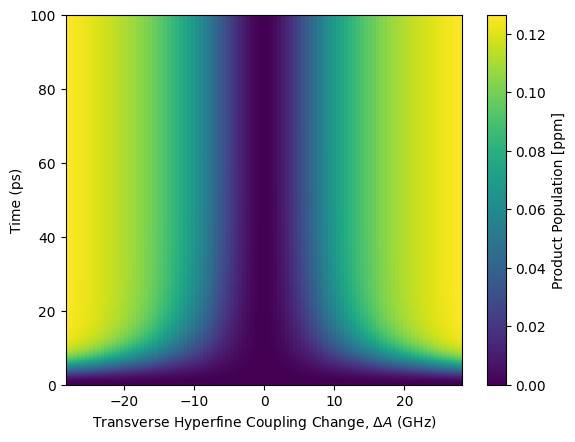

In [ ]:
plt.pcolor((gyr_e*dA_sweep*1e-9)/(2*np.pi),tlist*1e12,(expect_p_sweep*(1/(np.exp(dQ/(kb_eV*T))-1))*0.02*1e6).T)
plt.xlabel('Transverse Hyperfine Coupling Change, $\\Delta A \\ (\\mathrm{GHz})$')
plt.ylabel('Time (ps)')
plt.colorbar(label='Product Population [ppm]');

# g-tensor change: $\Delta g_z = g_{z}^{P450-I}-g_{0} = 1$

In [267]:
S_1 = [qt.tensor(sigma,qt.qeye(2),qt.qeye(2)) for sigma in tau]
S_2g = [qt.tensor(qt.qeye(2),qt.basis(2,0)*qt.basis(2,0).dag(),sigma) for sigma in tau]
S_2e = [qt.tensor(qt.qeye(2),qt.basis(2,1)*qt.basis(2,1).dag(),sigma) for sigma in tau]

In [ ]:
dQ = 0.3
He = qt.tensor(qt.qeye(2),(dQ/hbar_eV)*qt.basis(2,1)*qt.basis(2,1).dag(),qt.qeye(2))

bz = 1
gz_g = 2.02
gz_e = 1.02
Hb_1 = ((gz_g*mub_eV*bz)/hbar_eV)*S_1[2]
Hb_2g = ((gz_g*mub_eV*bz)/hbar_eV)*S_2g[2]
Hb_2e = ((gz_e*mub_eV*bz)/hbar_eV)*S_2e[2]

Hsim = He+Hb_1+Hb_2g+Hb_2e

In [269]:
s0_g = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,1))-qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,0)))
t0_g = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,1))+qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,0)))
tp_g = qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,0))
tm_g = qt.tensor(qt.basis(2,1),qt.basis(2,0),qt.basis(2,1))

s0_e = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,1))-qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,0)))
t0_e = (1/np.sqrt(2))*(qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,1))+qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,0)))
tp_e = qt.tensor(qt.basis(2,0),qt.basis(2,1),qt.basis(2,0))
tm_e = qt.tensor(qt.basis(2,1),qt.basis(2,1),qt.basis(2,1))

10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.13s. Est. time left: 00:00:00:00
30.0%. Run time:   0.20s. Est. time left: 00:00:00:00
40.0%. Run time:   0.26s. Est. time left: 00:00:00:00
50.0%. Run time:   0.32s. Est. time left: 00:00:00:00
60.0%. Run time:   0.40s. Est. time left: 00:00:00:00
70.0%. Run time:   0.46s. Est. time left: 00:00:00:00
80.0%. Run time:   0.52s. Est. time left: 00:00:00:00
90.0%. Run time:   0.59s. Est. time left: 00:00:00:00
100.0%. Run time:   0.67s. Est. time left: 00:00:00:00
Total run time:   0.67s


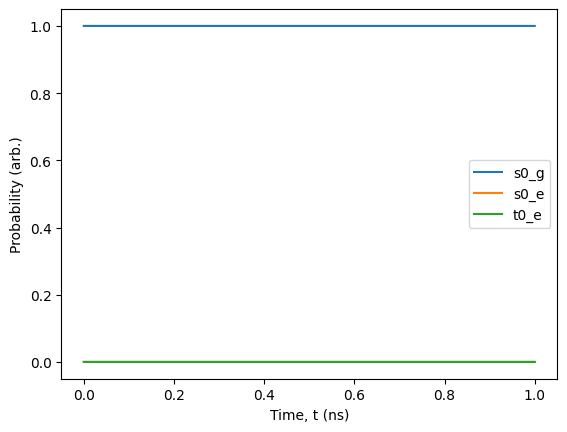

In [91]:
tlist = np.linspace(0,1e-9,10001)

result = qt.sesolve(
    Hsim,
    s0_g,
    tlist,
    e_ops = [s0_g.proj(),s0_e.proj(),t0_e.proj()],
    options = qt.Options(progress_bar='text'),
)

expect_label = ['s0_g','s0_e','t0_e']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();

10.0%. Run time:   1.21s. Est. time left: 00:00:00:10
20.0%. Run time:   2.45s. Est. time left: 00:00:00:09
30.0%. Run time:   3.67s. Est. time left: 00:00:00:08
40.0%. Run time:   4.91s. Est. time left: 00:00:00:07
50.0%. Run time:   6.13s. Est. time left: 00:00:00:06
60.0%. Run time:   7.34s. Est. time left: 00:00:00:04
70.0%. Run time:   8.62s. Est. time left: 00:00:00:03
80.0%. Run time:   9.82s. Est. time left: 00:00:00:02
90.0%. Run time:  11.03s. Est. time left: 00:00:00:01
100.0%. Run time:  12.33s. Est. time left: 00:00:00:00
Total run time:  12.33s


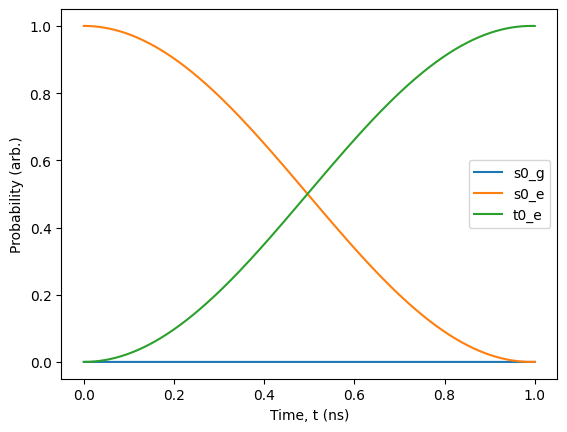

In [92]:
tlist = np.linspace(0,1e-9,10001)

result = qt.sesolve(
    Hsim,
    s0_e,
    tlist,
    e_ops = [s0_g.proj(),s0_e.proj(),t0_e.proj()],
    options = qt.Options(progress_bar='text'),
)

expect_label = ['s0_g','s0_e','t0_e']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();

In [ ]:
T = 100
c_down = s0_g*s0_e.dag()
gamma_down = 1/t1_fit(T,*popt_t1)
c_up = s0_e*s0_g.dag()
gamma_up = gamma_down/(np.exp(dQ/(kb_eV*T))-1)
print('Adiabatic Population in Excited State: '+str(1/(np.exp(dQ/(kb_eV*T))-1)))

Adiabatic Population in Excited State: 9.120756523964099e-06


10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.0%. Run time:   0.30s. Est. time left: 00:00:00:00
40.0%. Run time:   0.37s. Est. time left: 00:00:00:00
50.0%. Run time:   0.45s. Est. time left: 00:00:00:00
60.0%. Run time:   0.53s. Est. time left: 00:00:00:00
70.0%. Run time:   0.61s. Est. time left: 00:00:00:00
80.0%. Run time:   0.68s. Est. time left: 00:00:00:00
90.0%. Run time:   0.77s. Est. time left: 00:00:00:00
100.0%. Run time:   0.85s. Est. time left: 00:00:00:00
Total run time:   0.85s


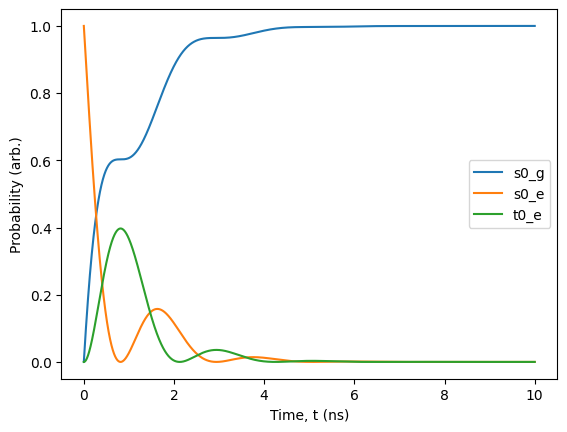

In [90]:
tlist = np.linspace(0,10e-9,10001)

result = qt.mesolve(
    Hsim,
    s0_e*s0_e.dag(),
    tlist,
    c_ops = [np.sqrt(gamma_down)*c_down, np.sqrt(gamma_up)*c_up],
    e_ops = [s0_g.proj(),s0_e.proj(),t0_e.proj()],
    options = qt.Options(progress_bar='text'),
)

expect_label = ['s0_g','s0_e','t0_e']
[plt.plot(tlist*1e9,expect,label=expect_label[i]) for i,expect in enumerate(result.expect)]
plt.xlabel('Time, t (ns)')
plt.ylabel('Probability (arb.)')
plt.legend();

In [ ]:
T = 300
c_down = s0_g*s0_e.dag()
gamma_down = 1/t1_fit(T,*popt_t1)
c_up = s0_e*s0_g.dag()
gamma_up = gamma_down/(np.exp(dQ/(kb_eV*T))-1)

bz_sweep = np.linspace(0,1,101)
tlist = np.linspace(0,0.4e-9,1001)
expect_s0_g_sweep = np.zeros((len(bz_sweep),len(tlist)))
expect_s0_e_sweep = np.zeros((len(bz_sweep),len(tlist)))
expect_t0_e_sweep = np.zeros((len(bz_sweep),len(tlist)))

for i,bz in enumerate(bz_sweep):
    Hb_1 = ((gz_g*mub_eV*bz)/hbar_eV)*S_1[2]
    Hb_2g = ((gz_g*mub_eV*bz)/hbar_eV)*S_2g[2]
    Hb_2e = ((gz_e*mub_eV*bz)/hbar_eV)*S_2e[2]
    Hb_I = (gyr_n*bz)*S_I[2]
    Hhf_2e = ((gz_g*mub_eV)/hbar_eV)*S_2e[0]*S_I[0]+((gz_g*mub_eV)/hbar_eV)*S_2e[1]*S_I[1]+((gz_g*mub_eV)/hbar_eV)*S_2e[2]*S_I[2]
    Hsim = He+Hb_1+Hb_2g+Hb_2e+Hb_I+Hhf_2e
    
    result = qt.mesolve(
        Hsim,
        s0_e*s0_e.dag(),
        tlist,
        c_ops = [np.sqrt(gamma_down)*c_down, np.sqrt(gamma_up)*c_up],
        e_ops = [s0_g.proj(),s0_e.proj(),t0_e.proj()],
        options = qt.Options(progress_bar=None),
    )

    expect_s0_g_sweep[i,:] = result.expect[0]
    expect_s0_e_sweep[i,:] = result.expect[1]
    expect_t0_e_sweep[i,:] = result.expect[2]

c:\Users\gbim9\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


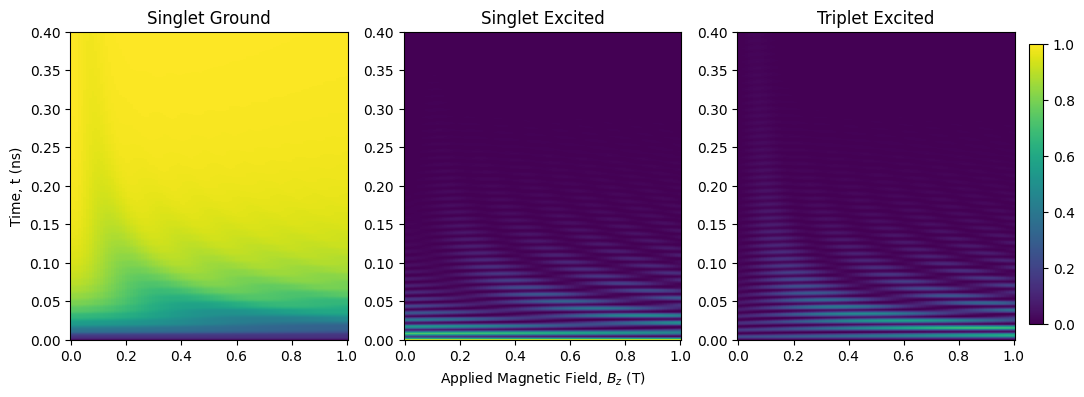

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
ax1.pcolor(bz_sweep,tlist*1e9,expect_s0_g_sweep.T,vmin=0,vmax=1)
ax1.set_ylabel('Time, t (ns)')
ax1.set_title('Singlet Ground')
ax2.pcolor(bz_sweep,tlist*1e9,expect_s0_e_sweep.T,vmin=0,vmax=1)
ax2.set_xlabel('Applied Magnetic Field, $B_{z}$ (T)')
ax2.set_title('Singlet Excited')
pc = ax3.pcolor(bz_sweep,tlist*1e9,expect_t0_e_sweep.T,vmin=0,vmax=1)
ax3.set_title('Triplet Excited')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
fig.colorbar(pc, cax=cbar_ax);